In [1]:
import pandas as pd
import numpy as np
import re
import csv
import string

import matplotlib.pyplot as plt
%matplotlib inline

import nltk
from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer,SnowballStemmer

from gensim.models import Word2Vec

from sklearn.preprocessing import MaxAbsScaler,MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.model_selection import train_test_split,GridSearchCV,KFold
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_score,recall_score,f1_score,make_scorer,fbeta_score
from sklearn.metrics import average_precision_score,plot_precision_recall_curve,precision_recall_curve
from sklearn.metrics import roc_auc_score,roc_curve, auc

from sklearn.naive_bayes import MultinomialNB,GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier,StackingClassifier, GradientBoostingClassifier,AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import lightgbm as lgb
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import LinearSVC

In [2]:
#import tweets dataset 
df = pd.read_csv('climate_change_tweets_sample-2020-05-16-17-57.csv')

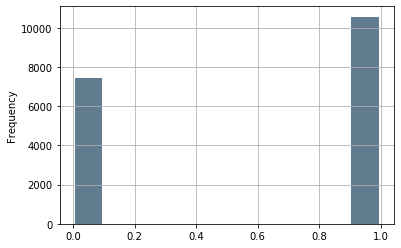

In [3]:
#show labels frequencies
df['label'].plot.hist(grid=True, rwidth=0.9,color='#607c8e')

In [4]:
tweets = df['text'].values
labels = df['label'].values

## TEXT PREPROCESSING

In [5]:
tweets[-5]

'EXCLUSIVE: Study Finds Temperature Adjustments Account For â€˜Nearly All Of The Warmingâ€™ In Climate Data http://dailycaller.com/2017/07/05/exclusive-study-finds-temperature-adjustments-account-for-nearly-all-of-the-warming-in-climate-data/?utm_source=site-share â€¦'

In [6]:
#REMOVE web external_links
tweets_short = np.array([' '.join([w for w in k.split(' ') if '.com' not in w]) for k in tweets])
tweets_short[-5]

'EXCLUSIVE: Study Finds Temperature Adjustments Account For â€˜Nearly All Of The Warmingâ€™ In Climate Data â€¦'

In [7]:
#remove non-ASCII characters

tweets_short = np.array([k.encode("ascii", "ignore").decode() for k in tweets_short])
tweets_short[-5]

'EXCLUSIVE: Study Finds Temperature Adjustments Account For Nearly All Of The Warming In Climate Data '

In [8]:
def translator(user_string):
    '''this function transforms abbrevations to normal words'''
    user_string = user_string.split(" ")
    j = 0
    for _str in user_string:
        # File path which consists of Abbreviations.
        fileName = "slang.txt"
        # File Access mode [Read Mode]
        accessMode = "r"
        with open(fileName, accessMode) as myCSVfile:
            # Reading file as CSV with delimiter as "=", so that abbreviation are stored in row[0] and phrases in row[1]
            dataFromFile = csv.reader(myCSVfile, delimiter="=")
            # Removing Special Characters.
            _str = re.sub('[^a-zA-Z0-9-_.]', '', _str)
            for row in dataFromFile:
                # Check if selected word matches short forms[LHS] in text file.
                if _str.upper() == row[0]:
                    # If match found replace it with its appropriate phrase in text file.
                    user_string[j] = row[1]
            myCSVfile.close()
        j = j + 1
    # Replacing commas with spaces for final output.
#     print(' '.join(user_string))
#     print('===================================================')
#     print('')
    return(' '.join(user_string))

print('EXAMPLE: asap ----> {}'.format(translator('asap')))


EXAMPLE: asap ----> As Soon As Possible


In [9]:
#ABBREVIATIONS FIX
tweets_short = np.array([translator(k) for k in tweets_short])
tweets_short[-5]

'EXCLUSIVE: Study Finds Temperature Adjustments Account For Nearly All Of The Warming In Climate Data '

In [10]:
#TO LOWERCASE
tweets_short = np.array([' '.join([ word.lower() for word in k.split() ]) for k in tweets_short]) 
tweets_short[-5]

'exclusive: study finds temperature adjustments account for nearly all of the warming in climate data'

In [11]:
#KEEP ALPHA_NUMERIC ONLY
tweets_short = np.array([" ".join(w for w in nltk.wordpunct_tokenize(k) if w.isalnum() ) for k in tweets_short])
tweets_short[-5]

'exclusive study finds temperature adjustments account for nearly all of the warming in climate data'

In [12]:
#DELETE PUNCTUATIONS
tweets_short = np.array([''.join([w for w in k if w not in string.punctuation]) for k in tweets_short])
tweets_short[-5]

'exclusive study finds temperature adjustments account for nearly all of the warming in climate data'

In [13]:
#REMOVE STOPWORDS
stop = stopwords.words('english')

tweets_short = np.array([' '.join([word for word in k.split() if word not in (stop)]) for k in tweets_short])
tweets_short[-5]

'exclusive study finds temperature adjustments account nearly warming climate data'

In [14]:
#LEMMATIZATION
lmtzr = WordNetLemmatizer()
tweets_short = np.array([' '.join([lmtzr.lemmatize(word,'v') for word in k.split() ]) for k in tweets_short])
tweets_short[-5]

'exclusive study find temperature adjustments account nearly warm climate data'

In [15]:
# import spacy
# # Load the spacy model that you have installed
# nlp = spacy.load('en_core_web_md')
# # process a sentence using the model
# doc = nlp("This is some text that I am processing with Spacy")
# # It's that simple - all of the vectors and words are assigned after this point
# # Get the vector for 'text':
# doc[3].vector
# # Get the mean vector for the entire sentence (useful for sentence classification etc.)
# doc.vector

In [16]:
# import spacy
# # Load the spacy model that you have installed
# nlp = spacy.load('en_core_web_md')

# tweets_short = np.array([nlp(str(k)).vector for k in tweets_short])

In [17]:
#STEMMING

#stm = PorterStemmer()
stm = SnowballStemmer('english')

tweets_short = np.array([' '.join([stm.stem(word) for word in k.split() ]) for k in tweets_short])
tweets_short[-5]

'exclus studi find temperatur adjust account near warm climat data'

In [18]:
#train_test split
test_size = 0.3
X_train, X_test, y_train, y_test = train_test_split(tweets_short,labels,test_size=test_size,shuffle=True,
                                                   random_state=101)

In [19]:
# import tensorflow.keras as K

# vocab_size = 10000

# tokens = K.preprocessing.text.Tokenizer(num_words=vocab_size)
# tokens.fit_on_texts(X_train)

# X_train = tokens.texts_to_matrix(X_train)
# X_test = tokens.texts_to_matrix(X_test)


In [20]:
#words vectorization

vectorizer = CountVectorizer()
#vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [21]:
#inputs scaling

scaler = MaxAbsScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## MODELS EVALUATION

In [22]:
kfcv = KFold(n_splits=5,shuffle=True,random_state=101) #<--- 5-fold cross-validation

### Logistic Regression

In [23]:
param_grid = {
    'penalty': ['l2'],
    'C': [0,0.1,0.5,1,5,10,100],
    'solver': ['lbfgs','liblinear','sag'],
    'multi_class': ['ovr']
}# Create a based model


clf = LogisticRegression()# Instantiate the grid search model
grid_search = GridSearchCV(estimator = clf, param_grid = param_grid, 
                           cv=kfcv,n_jobs = -1, verbose =2, scoring='accuracy')

grid_search.fit(X_train,y_train)
best_grid = grid_search.best_estimator_
best_params = best_grid.get_params()
print('score: {}'.format(round(grid_search.best_score_,4)))

print("Test set score : {:.3f}".format(accuracy_score(best_grid.predict(X_test), y_test)))

Fitting 5 folds for each of 21 candidates, totalling 105 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 105 out of 105 | elapsed:   13.1s finished


score: 0.9205
Test set score : 0.929


### Random Forest

In [24]:
# param_grid = {
#     'bootstrap': [True],
#     'max_depth': [10,20,50],
#     'max_features': [2,5,10],
#     'min_samples_leaf': [5,10,15],
#     'min_samples_split': [2,8, 12],
#     'n_estimators': [100],
#     'random_state':[101]
# }# Create a based model

param_grid = {}# Create a based model


clf = RandomForestClassifier()# Instantiate the grid search model
grid_search = GridSearchCV(estimator = clf, param_grid = param_grid, 
                           cv=kfcv,n_jobs = -1, verbose =2, scoring='accuracy')

grid_search.fit(X_train,y_train)
best_grid = grid_search.best_estimator_
best_params = best_grid.get_params()
print('score: {}'.format(round(grid_search.best_score_,4)))

print("Test set score : {:.3f}".format(accuracy_score(best_grid.predict(X_test), y_test)))

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   42.3s finished


score: 0.8993
Test set score : 0.904


### Multinomial Naive-Bayes

In [25]:
param_grid = {}# Create a based model


clf = MultinomialNB()
grid_search = GridSearchCV(estimator = clf, param_grid = param_grid, 
                           cv=kfcv,n_jobs = -1, verbose =2, scoring='accuracy')

grid_search.fit(X_train,y_train)
best_grid = grid_search.best_estimator_
best_params = best_grid.get_params()
print('score: {}'.format(round(grid_search.best_score_,4)))

print("Test set score : {:.3f}".format(accuracy_score(best_grid.predict(X_test), y_test)))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
score: 0.9135
Test set score : 0.921


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


### AdaBoosting

In [26]:
# param_grid = {}# Create a based model


# clf = AdaBoostClassifier()
# grid_search = GridSearchCV(estimator = clf, param_grid = param_grid, 
#                            cv=kfcv,n_jobs = -1, verbose =2, scoring='accuracy')

# grid_search.fit(X_train,y_train)
# best_grid = grid_search.best_estimator_
# best_params = best_grid.get_params()
# print('score: {}'.format(round(grid_search.best_score_,4)))

# print("Test set score : {:.3f}".format(accuracy_score(best_grid.predict(X_test), y_test)))

### MLP

In [27]:
# param_grid = {}# Create a based model


# clf = MLPClassifier()
# grid_search = GridSearchCV(estimator = clf, param_grid = param_grid, 
#                            cv=kfcv,n_jobs = -1, verbose =2, scoring='accuracy')

# grid_search.fit(X_train,y_train)
# best_grid = grid_search.best_estimator_
# best_params = best_grid.get_params()
# print('score: {}'.format(round(grid_search.best_score_,4)))

# print("Test set score : {:.3f}".format(accuracy_score(best_grid.predict(X_test), y_test)))

### GradientBoosting

In [28]:
# param_grid = {}# Create a based model


# clf = GradientBoostingClassifier()
# grid_search = GridSearchCV(estimator = clf, param_grid = param_grid, 
#                            cv=kfcv,n_jobs = -1, verbose =2, scoring='accuracy')

# grid_search.fit(X_train,y_train)
# best_grid = grid_search.best_estimator_
# best_params = best_grid.get_params()
# print('score: {}'.format(round(grid_search.best_score_,4)))

# print("Test set score : {:.3f}".format(accuracy_score(best_grid.predict(X_test), y_test)))

### Linear SVM-Classifier

In [29]:
param_grid = {}# Create a based model


clf = LinearSVC()
grid_search = GridSearchCV(estimator = clf, param_grid = param_grid, 
                           cv=kfcv,n_jobs = -1, verbose =2, scoring='accuracy')

grid_search.fit(X_train,y_train)
best_grid = grid_search.best_estimator_
best_params = best_grid.get_params()
print('score: {}'.format(round(grid_search.best_score_,4)))

print("Test set score : {:.3f}".format(accuracy_score(best_grid.predict(X_test), y_test)))

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


score: 0.912
Test set score : 0.920


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished


### XGBoosting

In [30]:
# param_grid = {}# Create a based model

# clf = xgb.XGBRFClassifier()
# grid_search = GridSearchCV(estimator = clf, param_grid = param_grid, 
#                            cv=kfcv,n_jobs = -1, verbose =2, scoring='accuracy')

# grid_search.fit(X_train,y_train)
# best_grid = grid_search.best_estimator_
# best_params = best_grid.get_params()
# print('score: {}'.format(round(grid_search.best_score_,4)))


# print("Test set score : {:.3f}".format(accuracy_score(best_grid.predict(X_test), y_test)))

### Gaussian Naive-Bayes

In [31]:
# param_grid = {}

# clf = GaussianNB()
# grid_search = GridSearchCV(estimator = clf, param_grid = param_grid, 
#                            cv=kfcv,n_jobs = -1, verbose =2, scoring='accuracy')

# grid_search.fit(X_train.toarray(),y_train)
# best_grid = grid_search.best_estimator_
# best_params = best_grid.get_params()
# print('score: {}'.format(round(grid_search.best_score_,4)))

# print("Test set score : {:.3f}".format(accuracy_score(best_grid.predict(X_test.toarray()), y_test)))

### LDA

In [32]:
# param_grid = {}

#clf = LinearDiscriminantAnalysis()
# grid_search = GridSearchCV(estimator = clf, param_grid = param_grid, 
#                            cv=kfcv,n_jobs = -1, verbose =2, scoring='accuracy')


# grid_search.fit(X_train,y_train)
# best_grid = grid_search.best_estimator_
# best_params = best_grid.get_params()
# print('score: {}'.format(round(grid_search.best_score_,4)))

# print("Test set score : {:.3f}".format(accuracy_score(best_grid.predict(X_test.toarray()), y_test)))

### LightGradientBoosting

In [33]:
param_grid = {}

clf = lgb.LGBMClassifier()
grid_search = GridSearchCV(estimator = clf, param_grid = param_grid, 
                           cv=kfcv,n_jobs = -1, verbose =2, scoring='accuracy')

grid_search.fit(X_train,y_train)
best_grid = grid_search.best_estimator_
best_params = best_grid.get_params()
print('score: {}'.format(round(grid_search.best_score_,4)))

print("Test set score : {:.3f}".format(accuracy_score(best_grid.predict(X_test.toarray()), y_test)))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.3s finished


score: 0.9027
Test set score : 0.909


### Stacked Model

In [34]:
estimators = [
     ('rf', RandomForestClassifier(n_estimators=10, random_state=42)),
     ('svc',LinearSVC()),
     ('NB',MultinomialNB()),
     ('lgb',lgb.LGBMClassifier()),
     ('log_reg',LogisticRegression())]
clf = StackingClassifier(estimators=estimators, final_estimator= LogisticRegression(),cv=kfcv,n_jobs=-1)


clf.fit(X_train, y_train)

StackingClassifier(cv=KFold(n_splits=5, random_state=101, shuffle=True),
                   estimators=[('rf',
                                RandomForestClassifier(bootstrap=True,
                                                       ccp_alpha=0.0,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=None,
                                                       max_features='auto',
                                                       max_leaf_nodes=None,
                                                       max_samples=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_s

In [35]:
print("Test set score : {:.3f}".format(accuracy_score(clf.predict(X_test), y_test)))

Test set score : 0.935


In [36]:
l = clf.final_estimator_

#models_coefficients
l.coef_

array([[ 1.29498914,  1.01676171,  2.87415462,  2.47211282, -0.72685002]])

In [37]:
pred = clf.predict(X_test)

print('##################################')
print('REPORT')
print('##################################')
print()
print('CONFUSION_MATRIX')
print()
print(confusion_matrix(y_test,pred))
print()
print('CLASSFICATION_REPORT')
print()
print(classification_report(y_test,pred))
print()
print('------------------------------------')
print('------------------------------------')

##################################
REPORT
##################################

CONFUSION_MATRIX

[[2077  173]
 [ 177 2976]]

CLASSFICATION_REPORT

              precision    recall  f1-score   support

           0       0.92      0.92      0.92      2250
           1       0.95      0.94      0.94      3153

    accuracy                           0.94      5403
   macro avg       0.93      0.93      0.93      5403
weighted avg       0.94      0.94      0.94      5403


------------------------------------
------------------------------------


In [38]:
pred = clf.predict(X_test)
accuracy = accuracy_score(y_test,pred)
precision = precision_score(y_test,pred)
recall = recall_score(y_test,pred)
f1 = f1_score(y_test,pred)
f2 = fbeta_score(y_test,pred,beta=2)
f5 = fbeta_score(y_test,pred,beta=2)

print('##########')
print('Accuracy: {}'.format(round(accuracy,4)))
print('Precision: {}'.format(round(precision,4)))
print('Recall: {}'.format(round(recall,4)))
print('f1_score: {}'.format(round(f1,4)))
print('f2_score: {}'.format(round(f2,4)))
print('f5_score: {}'.format(round(f5,4)))
print('##########')
print()

##########
Accuracy: 0.9352
Precision: 0.9451
Recall: 0.9439
f1_score: 0.9445
f2_score: 0.9441
f5_score: 0.9441
##########



Average precision-recall score: 0.98


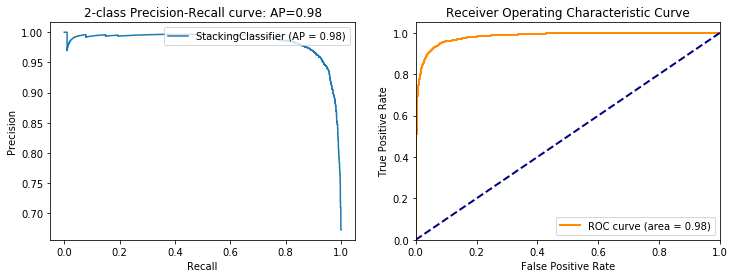

In [39]:
y_score = clf.decision_function(X_test)
average_precision = average_precision_score(y_test, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

fig, axes = plt.subplots(figsize=(12,4),nrows=1,ncols=2)
disp = plot_precision_recall_curve(clf, X_test, y_test,ax=axes[0])
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))
axes[0].legend(loc="upper right")


fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

#plt.figure()
lw = 2
axes[1].plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
axes[1].plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('Receiver Operating Characteristic Curve')
axes[1].legend(loc="lower right")
plt.show()